# Project Definition

## Project Overview

The project is aimed at developing an algorithm to identify the breed of a dog. Moreover, if the input image is a human one, the algorithm should rightly identify it so, and also spit out the closest resembling dog breed. 

The chosen domain of the problem is image classification using Deep Learnining - specifically, using Convolutional Neural Networks.

The origin of the image classification problem using Deep Learning, in general, links back to the [ImageNet Large Scale Visual Recognition Challenge](http://image-net.org/challenges/LSVRC/). This project, specifically, was originally developed by Udacity as one of its various options for a Data Scientist Capstone Project. The goal of this exercise is to solve the problem by building a dog breed classification model.

The data sets used in the project are:
- Images of different breeds of dogs (133 of them).
- Image of human faces.

The instructions to download the images are provided in the README file of this project. 

## Problem Statement

The specifics of the problem is as follows:

- Given an input image, identify whether a dog or a human is present in the image.
- If a dog has been identified, classify it as belonging to one of the 133 different dog breeds.
- If a human has been identifed, spit out the most resembling dog breed (fun part).
    
**Strategy for solving the problem**

We will solve the problem with an increasing level of complexity:

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Build a Complete Algorithm
* [Step 7](#step7): Algorithm Evaluation

The expected solution is the one that encapsulates and pieces together the various steps defined above to come up with an algorithm that would, for most of the time, rightly classify the input image into one of the 133 categories.

## Evaluation Metrics

We use a straight-forward metric for evaluating classification problems - **accuracy**. We could have looked at other metrics, such as, precision and recall. But, given the high cardinality of the categories, we would instead stick to accuracy (which is simply defined as the number of correct predictions divided by the total predictions). 


# Analysis

## Data Exploration & Visualization

Import necessary modules

In [35]:
import glob
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

Extract different dog breeds available in train, valid and test data sets.

In [13]:
train_categories = glob.glob('dogImages/train/*')
valid_categories = glob.glob('dogImages/valid/*')
test_categories = glob.glob('dogImages/test/*')

Check for the number of dog breeds available in each of train, valid and test data sets.

In [15]:
len(train_categories)

133

In [16]:
len(valid_categories)

133

In [17]:
len(test_categories)

133

Check for data distribution across dog breeds for each of train, valid and test data sets.|

In [18]:
def get_data_distribution(array):
    """
        Function to extract data distribution across dog breeds
        Input:
            array (list): glob file paths for train/valid/test data sets
        Output:
            dog_breeds (list)
            nimages (list)
    """
    dog_breeds, nimages = [], []
    for a in array:
        dog_breeds.append(a.split('/')[-1].split('.')[1])
        nimages.append(len(glob.glob(a+'/*')))
    
    return dog_breeds, nimages

In [19]:
dog_breeds_train, nimages_train = get_data_distribution(train_categories)

In [22]:
dog_breeds_valid, nimages_valid = get_data_distribution(valid_categories)

In [23]:
dog_breeds_test, nimages_test = get_data_distribution(test_categories)

Ensure that the same dog breeds are available across train, valid and test data sets

In [24]:
len(set(dog_breeds_train).intersection(set(dog_breeds_valid)).intersection(set(dog_breeds_test)))

133

Let's look at the data distribution across train, valid and test data sets

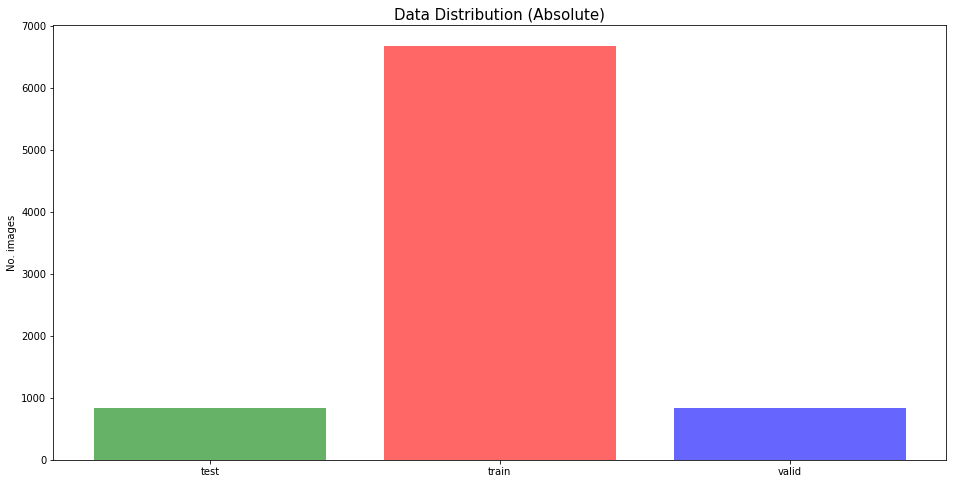

In [37]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.bar(['train', 'valid', 'test'], [sum(nimages_train), sum(nimages_valid), sum(nimages_test)],
      color=['r', 'b', 'g'], alpha=0.6)
plt.title('Data Distribution (Absolute)', fontsize=15)
ax.set_ylabel('No. images')
plt.show()

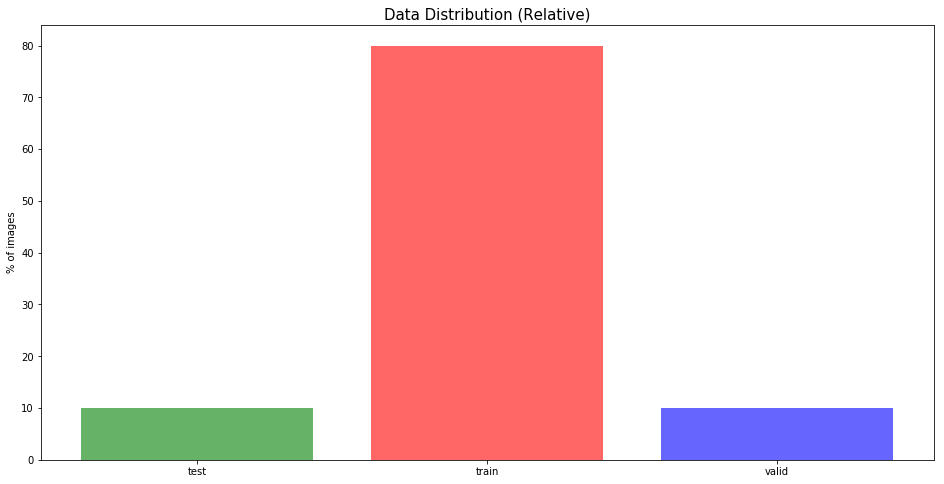

In [39]:
nimages_total = sum(nimages_train) + sum(nimages_valid) + sum(nimages_test)
fig, ax = plt.subplots(figsize=(16, 8))
ax.bar(np.array(['train', 'valid', 'test']), np.array([sum(nimages_train), sum(nimages_valid), sum(nimages_test)])*100/nimages_total,
      color=['r', 'b', 'g'], alpha=0.6)
plt.title('Data Distribution (Relative)', fontsize=15)
ax.set_ylabel('% of images')
plt.show()

**There is, approximately, a 80%-10%-10% split across training, validation and testing datasets**

Now, let's look at the distribution across categories.

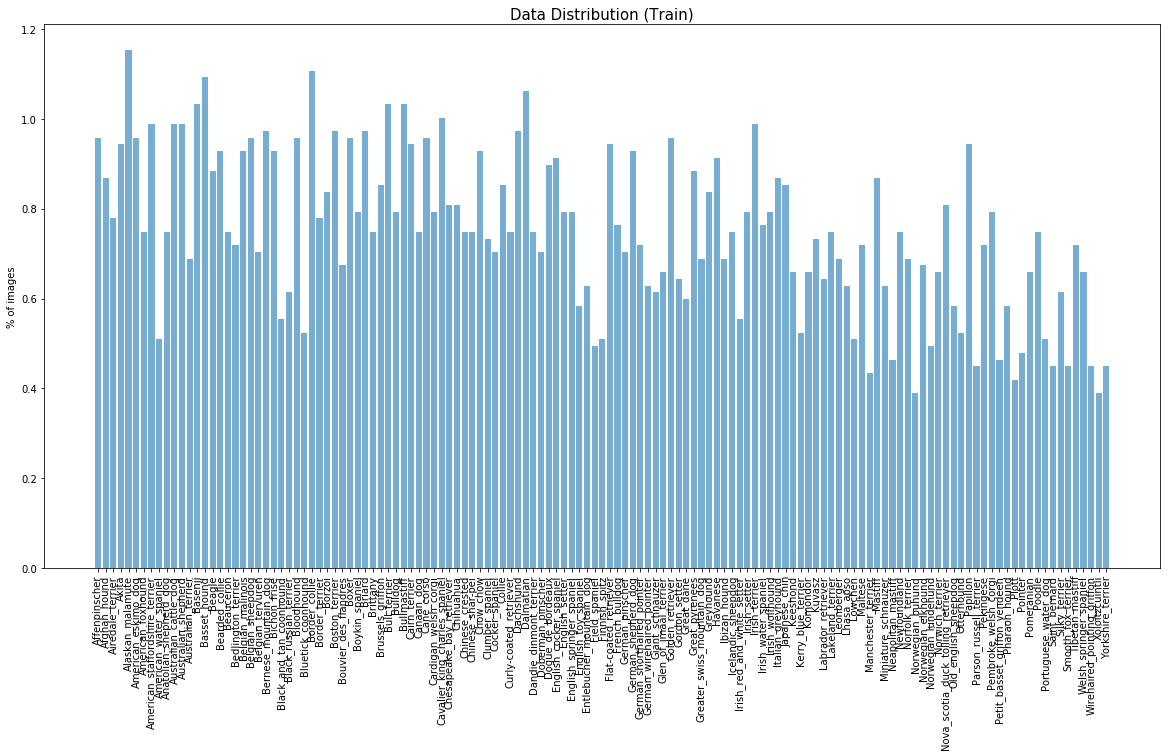

In [47]:
nimages_total = sum(nimages_train) + sum(nimages_valid) + sum(nimages_test)
fig, ax = plt.subplots(figsize=(20, 10))
ax.bar(np.array(dog_breeds_train), np.array(nimages_train)*100/sum(nimages_train), alpha=0.6)
plt.title('Data Distribution (Train)', fontsize=15)
ax.set_ylabel('% of images')
ax.xaxis.set_tick_params(rotation=90)
plt.show()

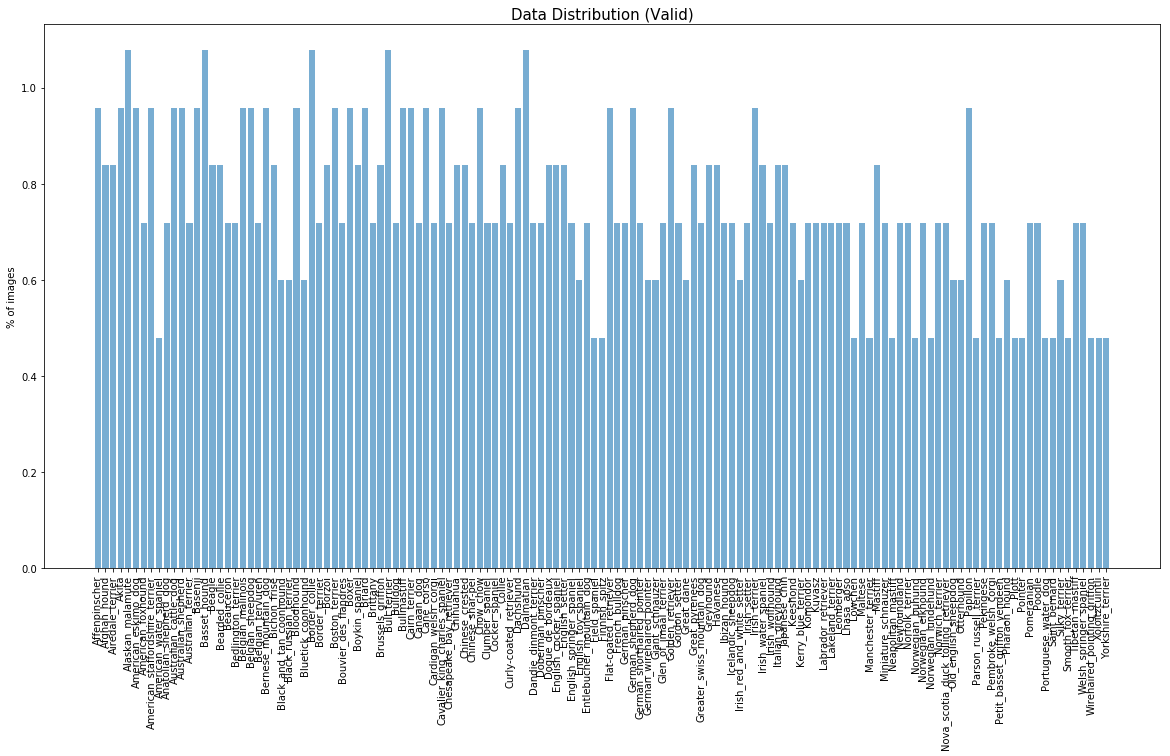

In [50]:
nimages_total = sum(nimages_train) + sum(nimages_valid) + sum(nimages_test)
fig, ax = plt.subplots(figsize=(20, 10))
ax.bar(np.array(dog_breeds_valid), np.array(nimages_valid)*100/sum(nimages_valid), alpha=0.6)
plt.title('Data Distribution (Valid)', fontsize=15)
ax.set_ylabel('% of images')
ax.xaxis.set_tick_params(rotation=90)
plt.show()

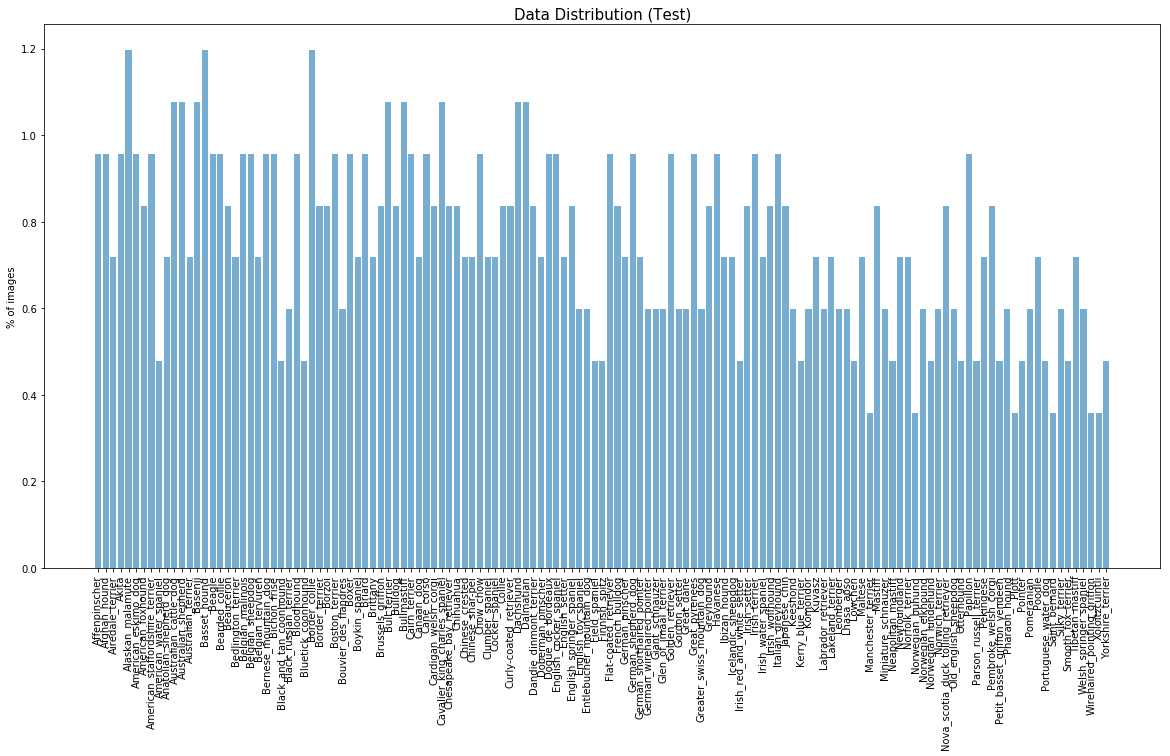

In [49]:
nimages_total = sum(nimages_train) + sum(nimages_valid) + sum(nimages_test)
fig, ax = plt.subplots(figsize=(20, 10))
ax.bar(np.array(dog_breeds_test), np.array(nimages_test)*100/sum(nimages_test), alpha=0.6)
plt.title('Data Distribution (Test)', fontsize=15)
ax.set_ylabel('% of images')
ax.xaxis.set_tick_params(rotation=90)
plt.show()

**The distribution across categories for each of train, valid and test data sets also rougly follow the same pattern. Also, although there seems to be a variance in the data distribution of different categories (0.5% to 1.2%), it is not exceptionally worrying.**

Now, let's look at the number of human faces in our data set

In [51]:
len(glob.glob('lfw/*/*'))

13233

This data set is not split across train, valid and test sets.

Onto modeling!

# Methodology

**Please note:** Relevant and necessary pre-processing steps required are mentioned as and when necessary.

<a id='step0'></a>
### Step 0: Import Datasets

#### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [2]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
### Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


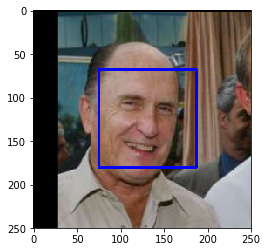

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

**Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter. **

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

#### Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [52]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

#### Assessmet of  the Human Face Detector

Let's look at the following questions: 
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 

- Out of the first 100 images from `human_files`, `face_detector` identified all 100 images as actually containing human faces in it. 
- Out of the first 100 images from `dog_files`, `face_detector` identified 12 images as containing human faces (instead of dog faces) in it.

In [5]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]

humans_detector=[face_detector(h) for h in human_files_short]    
dogs_detector=[face_detector(d) for d in dog_files_short]

In [6]:
print('Percentage of human faces detected in human_files_short - {}%'.format(sum(humans_detector)))
print('Percentage of human faces detected in dog_files_short - {}%'.format(sum(dogs_detector)))

Percentage of human faces detected in human_files_short - 100%
Percentage of human faces detected in dog_files_short - 12%


**Food for thought:** This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). Is this a reasonable expectation to pose on the user? 

The expectation of users providing a clear view of thier faces isn't a reasonable expectation to pose onto the users. Especially, in today's world where cameras are ubiquitous, users click photos from various angles and poses. A good algorithm is expected to catch-in all these images, and not just a select few where the images provide a clear view of faces. I think the use of convoultional neural nets should solve this problem since it has in-built translational invariance. I'm excited to see if convNet solves this!  


---
<a id='step2'></a>
### Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [8]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

#### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in our dataset!

In [9]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

#### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  For more information, please check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [10]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

#### Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), we will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [11]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

#### Assessment of the Dog Detector

Let's look at the following questions:  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

- 0 percentage of the images in `human_files_short` has a dog detected in it.
- 100% of the images in `dog_files_short` have dogs detected in them.

In [12]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
human_detector_resnet = [dog_detector(h) for h in human_files_short]
dog_detector_resnet = [dog_detector(d) for d in dog_files_short]

In [13]:
print('Percentage of dogs detected in human_files_short - {}%'.format(sum(human_detector_resnet)))
print('Percentage of dogs detected in dog_files_short - {}%'.format(sum(dog_detector_resnet)))

Percentage of dogs detected in human_files_short - 0%
Percentage of dogs detected in dog_files_short - 100%


---
<a id='step3'></a>
### Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, we will create a CNN that classifies dog breeds.  Our goal is to attain a test accuracy of at least 1%.  In Step 5 of this notebook, we will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We are careful with addingg too many trainable layers!  More parameters means longer training, which means we are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; we can extrapolate this estimate to figure out how long it will take for our algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

 

#### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [15]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:07<00:00, 105.80it/s]


#### Model Architecture

_ A Sample Model Architecture_

![Sample CNN](images/sample_cnn.png)
           

I have taken the basic guidelines from the sample architecture displayed above. However, in the first convolution layer, I've increased the filter size to (3,3). This is because, in the initial stages of the architecture, covering a larger filter area seemed more intuitive to me as doing so will give us more freedom in capturing patterns occuring over larger area. Gradually increasing the depth by using more filters in the subsequent layers, and gradually decreasing the height and width of the image by using max-pooling layers, as suggested by the sample architecture, seemed sensible to me. Increasing depth will capture more patterns, and decreasing height and width will reduce the number of parameters that we will have to fiddle with. Rectified linear units are used for activation functions as they allow the gradient information to flow smoothly during backpropagation. The softmax activation at the final layer is basically used to spit out probabilities. The number of additional parameters per each layer is taken into consideration while deciding on the number of layers. 

In [16]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

model.add(Conv2D(filters=16, kernel_size=(3,3), padding='valid', activation='relu',
                input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(filters=32, kernel_size=(2,2), padding='valid', activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(filters=64, kernel_size=(2,2), padding='valid', activation='relu'))
model.add(Flatten())
model.add(Dense(133, activation='softmax'))

### TODO: Define your architecture.

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 110, 110, 32)      2080      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 55, 55, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 54, 54, 64)        8256      
_________________________________________________________________
flatten_2 (Flatten)          (None, 186624)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 133)               24821125  
Total para

#### Compile the Model

In [17]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

#### Train the Model


In [18]:
from keras.callbacks import ModelCheckpoint  

### specify the number of epochs that you would like to use to train the model.

epochs = 5

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/5
6660/6680 [============================>.] - ETA: 1s - loss: 5.0649 - acc: 0.0257
Epoch 00001: val_loss improved from inf to 4.58246, saving model to saved_models/weights.best.from_scratch.hdf5
6680/6680 [==============================] - 523s 78ms/step - loss: 5.0638 - acc: 0.0256 - val_loss: 4.5825 - val_acc: 0.0551
Epoch 2/5
6660/6680 [============================>.] - ETA: 1s - loss: 3.3707 - acc: 0.2806
Epoch 00002: val_loss did not improve
6680/6680 [==============================] - 450s 67ms/step - loss: 3.3702 - acc: 0.2805 - val_loss: 5.0633 - val_acc: 0.0491
Epoch 3/5
6660/6680 [============================>.] - ETA: 4s - loss: 0.6015 - acc: 0.8649
Epoch 00003: val_loss did not improve
6680/6680 [==============================] - 1503s 225ms/step - loss: 0.6017 - acc: 0.8648 - val_loss: 7.8481 - val_acc: 0.0551
Epoch 4/5
6660/6680 [============================>.] - ETA: 4s - loss: 0.1834 - acc: 0.9682
Epoch 00004: val_

#### Load the Model with the Best Validation Loss

In [19]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

#### Test the Model


In [20]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 4.1866%


---
<a id='step4'></a>
### Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, we will get a chance to use transfer learning to train our own CNN.

#### Obtain Bottleneck Features

In [21]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

#### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [22]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


#### Compile the Model

In [23]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

#### Train the Model

In [24]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6560/6680 [============================>.] - ETA: 0s - loss: 12.0426 - acc: 0.1381
Epoch 00001: val_loss improved from inf to 10.62629, saving model to saved_models/weights.best.VGG16.hdf5
6680/6680 [==============================] - 3s 509us/step - loss: 12.0127 - acc: 0.1404 - val_loss: 10.6263 - val_acc: 0.2479
Epoch 2/20
6620/6680 [============================>.] - ETA: 0s - loss: 10.0233 - acc: 0.2947
Epoch 00002: val_loss improved from 10.62629 to 10.06883, saving model to saved_models/weights.best.VGG16.hdf5
6680/6680 [==============================] - 2s 253us/step - loss: 10.0212 - acc: 0.2949 - val_loss: 10.0688 - val_acc: 0.2826
Epoch 3/20
6640/6680 [============================>.] - ETA: 0s - loss: 9.6368 - acc: 0.3417
Epoch 00003: val_loss improved from 10.06883 to 9.77753, saving model to saved_models/weights.best.VGG16.hdf5
6680/6680 [==============================] - 2s 251us/step - loss: 9.6317 - acc: 0.3422 - v

#### Load the Model with the Best Validation Loss

In [25]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

#### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [26]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 49.7608%


In [53]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
### Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

We will now use transfer learning to create a CNN that can identify dog breed from images.  

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, we will use the bottleneck features from a different pre-trained model.  To make things easier, we have pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

#### Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

### ResNet-50

In [28]:
### Obtain bottleneck features from another pre-trained CNN.
bottleneck_features = np.load('bottleneck_features/DogResnet50Data.npz')
train_resnet = bottleneck_features['train']
valid_resnet = bottleneck_features['valid']
test_resnet = bottleneck_features['test']

####  Model Architecture


__Answer:__ 

I basically wanted to test all the four architectures - VGG19, ResNet, Inception and Xception - keeping all the other parameters constant. Since we've already tested VGG16 with `rms_prop` optimizer, `categorical_crossentropy` loss function, 20 epochs, batch size of 20, an additional GlobalAveragePooling layer and a softmax dense layer at the end, I've used the same parameters for different bottleneck features. The reason why I think the architechtures are suitable for the current problem is because all these architectures' weights were fine-tuned usind ImageNet data which contained all the different breeds of dogs. Hence, these architectures have already learnt to differentiate amongst the various dog breeds (and more). As is apparent, the Xception arcitecture performs the best on the test set. 


In [29]:
### Define  architecture.
resnet = Sequential()
resnet.add(GlobalAveragePooling2D(input_shape=train_resnet.shape[1:]))
resnet.add(Dense(133, activation='softmax'))

resnet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


#### Compile the Model

In [30]:
resnet.compile(optimizer='rmsprop', metrics=['accuracy'], loss='categorical_crossentropy')

####  Train the Model

In [31]:

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.resnet.hdf5',
                              verbose=1, save_best_only=True)
resnet.fit(train_resnet, train_targets, 
           validation_data=(valid_resnet, valid_targets),
           verbose=1, epochs=20, batch_size=20,callbacks=[checkpointer])

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6520/6680 [============================>.] - ETA: 0s - loss: 1.6401 - acc: 0.6009
Epoch 00001: val_loss improved from inf to 0.83797, saving model to saved_models/weights.best.resnet.hdf5
6680/6680 [==============================] - 3s 447us/step - loss: 1.6211 - acc: 0.6040 - val_loss: 0.8380 - val_acc: 0.7437
Epoch 2/20
6620/6680 [============================>.] - ETA: 0s - loss: 0.4381 - acc: 0.8610
Epoch 00002: val_loss improved from 0.83797 to 0.72854, saving model to saved_models/weights.best.resnet.hdf5
6680/6680 [==============================] - 2s 347us/step - loss: 0.4387 - acc: 0.8609 - val_loss: 0.7285 - val_acc: 0.7892
Epoch 3/20
6660/6680 [============================>.] - ETA: 0s - loss: 0.2604 - acc: 0.9180
Epoch 00003: val_loss improved from 0.72854 to 0.68908, saving model to saved_models/weights.best.resnet.hdf5
6680/6680 [==============================] - 3s 374us/step - loss: 0.2609 - acc: 0.9178 - val_loss

####  Load the Model with the Best Validation Loss

In [32]:
resnet.load_weights('saved_models/weights.best.resnet.hdf5')

#### Test the Model

In [33]:
### Calculate classification accuracy on the test dataset.
resnet_predictions = [np.argmax(resnet.predict(np.expand_dims(tensor,axis=0))) for tensor in test_resnet]

resnet_accuracy = 100*np.sum(np.array(resnet_predictions)==np.argmax(test_targets, axis=1))/len(test_targets)
print("(Resnet) Test accuracy: %.4f%%" % resnet_accuracy)

(Resnet) Test accuracy: 79.9043%


### VGG19

In [34]:
bottleneck_features = np.load('bottleneck_features/DogVGG19Data.npz')
train_VGG19 = bottleneck_features['train']
valid_VGG19 = bottleneck_features['valid']
test_VGG19 = bottleneck_features['test']

VGG19 = Sequential()
VGG19.add(GlobalAveragePooling2D(input_shape=train_VGG19.shape[1:]))
VGG19.add(Dense(133, activation='softmax'))

VGG19.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_3 ( (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


In [35]:
VGG19.compile(optimizer='rmsprop', metrics=['accuracy'], loss='categorical_crossentropy')

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG19.hdf5', verbose=1, save_best_only=True)
VGG19.fit(train_VGG19, train_targets, validation_data=(valid_VGG19, valid_targets), epochs=20, batch_size=20,
         verbose=1, callbacks=[checkpointer])

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6640/6680 [============================>.] - ETA: 0s - loss: 11.3931 - acc: 0.1542
Epoch 00001: val_loss improved from inf to 9.78447, saving model to saved_models/weights.best.VGG19.hdf5
6680/6680 [==============================] - 3s 486us/step - loss: 11.3781 - acc: 0.1552 - val_loss: 9.7845 - val_acc: 0.2335
Epoch 2/20
6600/6680 [============================>.] - ETA: 0s - loss: 8.9718 - acc: 0.3338
Epoch 00002: val_loss improved from 9.78447 to 8.86595, saving model to saved_models/weights.best.VGG19.hdf5
6680/6680 [==============================] - 2s 290us/step - loss: 8.9610 - acc: 0.3343 - val_loss: 8.8659 - val_acc: 0.3329
Epoch 3/20
6640/6680 [============================>.] - ETA: 0s - loss: 8.3210 - acc: 0.4111
Epoch 00003: val_loss improved from 8.86595 to 8.71709, saving model to saved_models/weights.best.VGG19.hdf5
6680/6680 [==============================] - 2s 284us/step - loss: 8.3236 - acc: 0.4111 - val_loss:

In [36]:
VGG19.load_weights('saved_models/weights.best.VGG19.hdf5')

VGG19_predictions = [np.argmax(VGG19.predict(np.expand_dims(tensor, axis=0))) for tensor in test_VGG19]
VGG19_accuracy = 100*np.sum(np.array(VGG19_predictions)==np.argmax(test_targets, axis=1))/len(test_targets)
print(' (VGG19) Test accuracy: %.4f%%' % VGG19_accuracy)

 (VGG19) Test accuracy: 50.0000%


### Inception

In [37]:
bottleneck_features = np.load('bottleneck_features/DogInceptionV3Data.npz')
train_inception = bottleneck_features['train']
valid_inception = bottleneck_features['valid']
test_inception = bottleneck_features['test']

inception = Sequential()
inception.add(GlobalAveragePooling2D(input_shape=train_inception.shape[1:]))
inception.add(Dense(133, activation='softmax'))

inception.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_4 ( (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


In [38]:
inception.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.inception.hdf5', verbose=1, save_best_only=True)
inception.fit(train_inception, train_targets, validation_data=(valid_inception, valid_targets),
             epochs=20, batch_size=20, verbose=1, callbacks=[checkpointer])

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6660/6680 [============================>.] - ETA: 0s - loss: 1.1401 - acc: 0.7188
Epoch 00001: val_loss improved from inf to 0.64834, saving model to saved_models/weights.best.inception.hdf5
6680/6680 [==============================] - 7s 1ms/step - loss: 1.1398 - acc: 0.7192 - val_loss: 0.6483 - val_acc: 0.8048
Epoch 2/20
6620/6680 [============================>.] - ETA: 0s - loss: 0.4802 - acc: 0.8497
Epoch 00002: val_loss did not improve
6680/6680 [==============================] - 3s 473us/step - loss: 0.4796 - acc: 0.8497 - val_loss: 0.6501 - val_acc: 0.8275
Epoch 3/20
6640/6680 [============================>.] - ETA: 0s - loss: 0.3662 - acc: 0.8867
Epoch 00003: val_loss did not improve
6680/6680 [==============================] - 3s 451us/step - loss: 0.3645 - acc: 0.8874 - val_loss: 0.6518 - val_acc: 0.8287
Epoch 4/20
6560/6680 [============================>.] - ETA: 0s - loss: 0.3016 - acc: 0.9110
Epoch 00004: val_loss d

In [39]:
inception.load_weights('saved_models/weights.best.inception.hdf5')

inception_predictions = [ np.argmax(inception.predict(np.expand_dims(tensor, axis=0))) for tensor in test_inception]
inception_accuracy = 100*np.sum(np.array(inception_predictions)==np.argmax(test_targets, axis=1))/len(test_targets)
print(' (Inception) Test accuracy: %.4f%%' % inception_accuracy)

 (Inception) Test accuracy: 77.7512%


### Xception

In [40]:
bottleneck_features = np.load('bottleneck_features/DogXceptionData.npz')
train_xception = bottleneck_features['train']
valid_xception = bottleneck_features['valid']
test_xception = bottleneck_features['test']

xception = Sequential()
xception.add(GlobalAveragePooling2D(input_shape=train_xception.shape[1:]))
xception.add(Dense(133, activation='softmax'))

xception.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_5 ( (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


In [41]:
xception.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.xception.hdf5', save_best_only=True, verbose=1)
xception.fit(train_xception, train_targets, validation_data=(valid_xception, valid_targets), epochs=20, batch_size=20,
            callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6660/6680 [============================>.] - ETA: 0s - loss: 1.0419 - acc: 0.7483
Epoch 00001: val_loss improved from inf to 0.51367, saving model to saved_models/weights.best.xception.hdf5
6680/6680 [==============================] - 13s 2ms/step - loss: 1.0398 - acc: 0.7490 - val_loss: 0.5137 - val_acc: 0.8371
Epoch 2/20
6660/6680 [============================>.] - ETA: 0s - loss: 0.3979 - acc: 0.8749
Epoch 00002: val_loss improved from 0.51367 to 0.49582, saving model to saved_models/weights.best.xception.hdf5
6680/6680 [==============================] - 7s 980us/step - loss: 0.3984 - acc: 0.8749 - val_loss: 0.4958 - val_acc: 0.8371
Epoch 3/20
6640/6680 [============================>.] - ETA: 0s - loss: 0.3247 - acc: 0.8962
Epoch 00003: val_loss improved from 0.49582 to 0.47832, saving model to saved_models/weights.best.xception.hdf5
6680/6680 [==============================] - 4s 665us/step - loss: 0.3244 - acc: 0.8960 - val

In [42]:
xception.load_weights('saved_models/weights.best.xception.hdf5')

xception_predictions = [ np.argmax(xception.predict(np.expand_dims(tensor, axis=0))) for tensor in test_xception]
xception_accuracy = 100*np.sum(np.array(xception_predictions==np.argmax(test_targets, axis=1)))/len(test_targets)

print(' (Xception) Test accuracy: %.4f%%' % xception_accuracy)

 (Xception) Test accuracy: 83.2536%


### Predict Dog Breed with the Model

Let's now write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, our function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to our chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [43]:

#Note: I'm not re-building the model as I already have the model built.
def predict_dog_breed(image_path, model=xception, dog_names=dog_names):
    """
        Fuction to predict the dog breed 
        Inputs:
            image_path: path to the input image
            model: model to be used for prediction
            dog_names: array containing dog breeds
        Returns:
            predicted dog breed
    """
    bottleneck_features=extract_Xception(path_to_tensor(image_path))
    prediction=dog_names[np.argmax(model.predict(bottleneck_features),axis=1)[0]]
    return prediction
    

In [44]:
predict_dog_breed(dog_files_short[0])

'Kuvasz'

Indeed, the prediction is correct. 

In [46]:
dog_names[np.argmax(train_targets[0])]

'Kuvasz'

---
<a id='step6'></a>
### Step 6: Build a Complete Algorithm

Finally, we build an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.


In [96]:
def identify_image(image_path, cnn=xception):
    """
        Function to predict the dog breed of an input image
        Inputs:
            image_path: path to the image on which prediction is to be made
            cnn: model to be used for prediction
        Output:
            Model prediction
    """
    #extract bottleneck features
    bottleneck_features=extract_Xception(path_to_tensor(image_path))
    #predict the dog breed
    predictions=cnn.predict(bottleneck_features)
    confidence=predictions.max()
    dog_breed=predict_dog_breed(image_path)
    
    img=cv2.imread(image_path)
    img_rgb=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    #output the prediction
    if dog_detector(image_path):
        print('Hello, dog!')
        plt.imshow(img_rgb)
        print('You belong to the breed '+dog_breed+' with '+str(round(confidence*100,2))+'% confidence')
    elif face_detector(image_path):
        print('Hello, human!')
        plt.imshow(img_rgb)
        print('You look like a '+dog_breed+' with '+str(round(confidence*100,2))+'% confidence')
    else:
        print('Error! Neither dogs nor humans detected in the image.')
        plt.imshow(img_rgb)
    plt.show()

Hello, dog!
You belong to the breed Great_pyrenees with 91.74% confidence


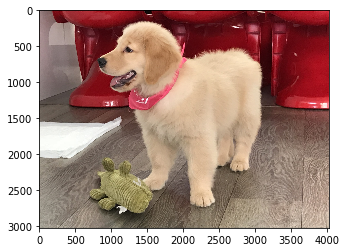

In [83]:
identify_image('Image uploaded from iOS.jpg')

# Results

## Model Evaluation and Validation

Before we go ahead and evaluate the algorithm, let's summarize the accuracy metric for the various architectures employed.

|Architecture|Trainable Parameters|Train Accuracy|Valid Accuracy|Test Accuracy|
|--|--|--|--|
|Custom| 24,831,909 |97.6%| 5.03% | 4.19%|
|VGG16| 68,229 |63.58%| 49.7% | 49.76%|
|VGG19| 68,229|61.74% | 48.14%|50.0%
|ResNet-50| 272,517|99.82%| 82.75%| 79.9%|
|Inception| 272,517|98.88%|86.23%|77.75%|
|**Xception**| 272,517|97.98%|84.91%|**83.25%**|

---
<a id='step7'></a>
### Step 7: Algorithm Evaluation

In this section, we will take our new algorithm for a spin! 


Hello, dog!
You belong to the breed German_shepherd_dog with 98.71% confidence


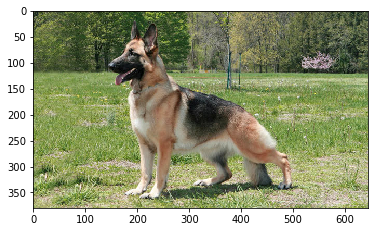

In [84]:
identify_image('images/german_shepard.jpeg')

Hello, dog!
You belong to the breed Dogue_de_bordeaux with 48.82% confidence


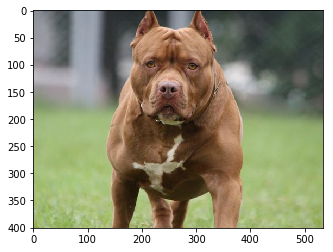

In [86]:
identify_image('images/pitbull.jpg')

Hello, dog!
You belong to the breed Bulldog with 95.15% confidence


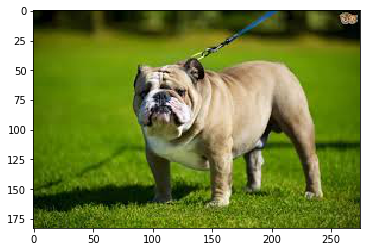

In [87]:
identify_image('images/bull_dog.jpeg')

Error! Neither dogs nor humans detected in the image.


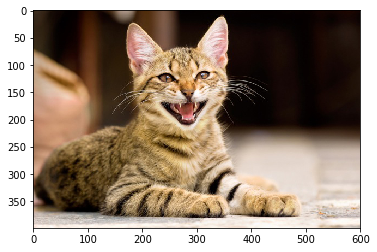

In [95]:
identify_image('images/cat.jpg')

Hello, human!
You look like a Portuguese_water_dog with 14.69% confidence


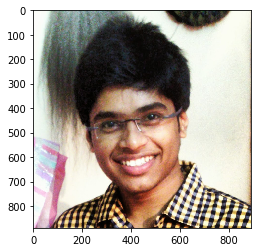

In [97]:
identify_image('images/human.jpg')

Hello, human!
You look like a Dachshund with 8.54% confidence


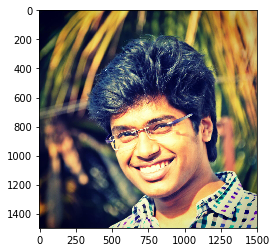

In [98]:
identify_image('images/human1.jpg')

## Justification



The model's output just fell a tad short of our expectations. The model correctly predicts 5 out of the 6 input images. It correctly identified the dog breeds of German shepherd and bull dog. Also, it was right in idenfying the human faces and cats in the input images. However, it got confused with pitbull image, and actually thinks that it belongs to a type of French breeds - Dogue_de_bordeaux. But, the good part is that the confidence in this prediction is low.

As was thoroughly discussed above, the transfer learning approach made it possible for us to achive this level of accuracy over our initial custom CNN model built from scratch.


# Conclusion

## Reflection

In summary, we've built a function to `identify_image` which does the following tasks:
- Check for the presence of a dog using `dog_detector` function, which in turn uses `ResNet50` architecture to check if the prediction falls between 151-268 (the key ranges for dog breeds). If so, then the function outputs the dog breed predicted using the `predict_dog_breed` function, which in turn uses a variant of the `Xception` architecture built using transfer learning. 
- If a dog is not detected, we check for the presence of a human in the input image using `face_detector` function. The `face_detector` function uses OpenCV's Haar feature-based cascade classifiers to detect the presence of a human face in the input image. If a human face is found, we also output the closest resembling dog breed using the same `predict_dog_breed` function described above. 
- If neither a human nor a dog is found in the image, we output the error message. 

The aspects of the projects that I particularly found interesting are:
- The efficacy of transfer learning: how by using bottleneck features and building minimal layers on top of them we could achieve an impressive boost up in the accuracy.
- The ability to chain independent modules to achieve an impressive application. For this specific project, we've used OpenCV's face detector algorithm and clubbed it with Deep Learning architectures to come up with an interesting and fun application.

## Future Work for Improvement

The three potential points of improvement in the algorithm are:
- The algorithm can be improved to be able to differentiate between fully grown dogs and puppies. This would be an additional imporovement to our present model wherein we not only classify the dog breeds, but also whether the dog is a fully grown one or a puppy. 
- It can also be fine-tuned to correctly identify different breeds of dogs/cats in the same image. Incorporating the will allow the model to identify multiple dogs and their respective breeds in the input image and not just a single one.
- Also, for human input images, the model can be further improved to bring the confidence down to 0%. Although the present model rightly classifies human images with ~10-15% confidence, striving to bring this further down will help improve the model performance.